# CS-6600 Assignment #6 - Exploratory Data Analysis



**Updated after feedback. Also has model and results**

Your analysis should be below. Unlike previous assignments, there's not a lot of scaffolding provided for you. It's mostly up to you.

There are three parts to this assignment:

Part 1: Identify the team with whom you’ll be working on your final project. Teams can
consist of anywhere from 2 to 4 people. Please include the names of all team members
at the top of your submission. Every team member will submit their own Jupyter
notebook on Canvas, but they should all be identical.

Part 2: Identify the dataset you want to study, and identify three questions you want to
ask that you think the data might answer. Why three and not one? Because after some
analysis you might realize a question you originally thought was more interesting isn’t,
or you might find a question you initially thought would be more tractable isn’t. Having
three questions gives you some flexibility so you don’t have to go back to the beginning
if things don’t go as expected.

Part 3: Perform an exploratory data analysis along the lines of Lecture 9. Examine the
different variables and their categories, see which variables are correlated, check for
outliers and figure out what you’re going to do with them, and determine the proper way
to encode things like categorical variables. This part should involve at least two data
visualizations, and should conclude with you building a pipeline that takes the initial raw
data and converts it into the format you can use for modeling. Finally, determine the
question you’ll investigate with this data, and how you’ll evaluate the success of your
investigation.

Your submission should be a Jupyter notebook that walks through all three parts, and
lets anybody reading it understand your process and the decisions you made.

1) How do little things like title, description, hashtags, time of posting affect views, likes, comments, etc?

2) Does length of video affect the amount of views and average watch time? (If it is a long video do people click off of it "because it may be too long"?)

3) Using the gender of the person's account, is the average watchtime/audience retention different over different genders? (Due to privacy reasons this might not be possible to look into)

4) Do videos with more comments tend to have more likes? (This can be used to somehow "ask a question" in the video to engage more with the viewers in the comments, and in-turn may make them feel welcome to like the video too)


Main Question: **What factors most significantly influence the number of views on videos on YouTube?** (Obviously the youtube algorithm does its thing, so "significant" in this case will most likely be small)

In [ ]:
!pip install google-auth google-auth-oauthlib google-auth-httplib2 google-api-python-client pandas matplotlib seaborn

!pip install pandas

!pip install isodate

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from google.auth import default

from googleapiclient.discovery import build  # Import the build function to use the YouTube Data API


from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer

from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer

from sklearn.metrics import root_mean_squared_error

from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
#Important Variables
#api_key = 'key here'
# channel_id = 'UCe-G8LHgHhV5o_4BWqbd3qg'

other_rl_channels = [#'UC1GFqqHIBaiCW1ivJJCFTvg', #amustycow
                     'UCRi4YlWuLFCucOx_rk-ddsg', #ApparentlyJack
                     'UCRLM6B6rGXDSJawUH_mHHPw', #Retals
                     #'UCG4lp2gYoPTnsOFySJyEsmg', #AlphaKep
                     'UC1JPEwMqLaI96qRUKNp3_ow', #SquishyMuffinz
                     #'UCH79ay54uFoaqES211Mi9_A', #CozyP
                     #'UCkNYoWK1LqjFhxYI6BM_kOA', #Lethamyr
                     #'UCOnymt0Mx9N6ZZizJKQeiAw', #JamacianCoconut
                     #'UC8zoEdRq3RoLNqNuYkLPRkg' #MizuRL
                     ]

# channels = ['UCRi4YlWuLFCucOx_rk-ddsg',
#             'UCRLM6B6rGXDSJawUH_mHHPw',
#             'UC1JPEwMqLaI96qRUKNp3_ow',
#             ]

In [ ]:
youtube = build('youtube', 'v3', developerKey=api_key)

This is a dataset of YouTuber's total video id's. Youtube holds a "playlist" of a single youtuber's videos under one playlist id, so that is what I am pulling. I got these from a site by just typing in their username and it gave me the playlist_ids. I am hoping to be able to pull all their videos and come up with certain things they do (keywords they use, time of posting, etc). There are quite a bit of features, so I will put a link to the site. The main ones I am using will be related to a single video, like views, duration of video, time of posting, title, description, those type of metrics.

https://developers.google.com/youtube/v3/docs

## Function to get channel statistics

In [ ]:
def get_channel_stats(youtube, other_rl_channels):
  all_youtuber_data = []
  request = youtube.channels().list(
      part='snippet,contentDetails, statistics',
      id=','.join(other_rl_channels))

  response = request.execute()

  #This will grab most of our variables of each channel
  for i in range(len(response['items'])):
    data = dict(Channel_name = response['items'][i]['snippet']['title'],
                Subscribers = response['items'][i]['statistics']['subscriberCount'],
                Views = response['items'][i]['statistics']['viewCount'],
                Total_videos = response['items'][i]['statistics']['videoCount'],
                playlist_id = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])

    all_youtuber_data.append(data)

  return all_youtuber_data

  #videos longer than 1-3 minutes
  #videos within the last 2-3 months
  #Keywords learn, how to, tutorial, settings (or even best settings)


In [ ]:
channels_statistics = get_channel_stats(youtube, other_rl_channels)

In [ ]:
channels_data = pd.DataFrame(channels_statistics)
channels_data['Subscribers'] = pd.to_numeric(channels_data['Subscribers'])
channels_data['Views'] = pd.to_numeric(channels_data['Views'])
channels_data['Total_videos'] = pd.to_numeric(channels_data['Total_videos'])
channels_data

,Channel_name,Subscribers,Views,Total_videos,playlist_id
0,ApparentlyJack,216000,47789850,752,UURi4YlWuLFCucOx_rk-ddsg
1,Retals,210000,89675189,1267,UURLM6B6rGXDSJawUH_mHHPw
2,SquishyMuffinz,1380000,278467197,1283,UU1JPEwMqLaI96qRUKNp3_ow


In [ ]:
channels_data.dtypes

,0
Channel_name,object
Subscribers,int64
Views,int64
Total_videos,int64
playlist_id,object


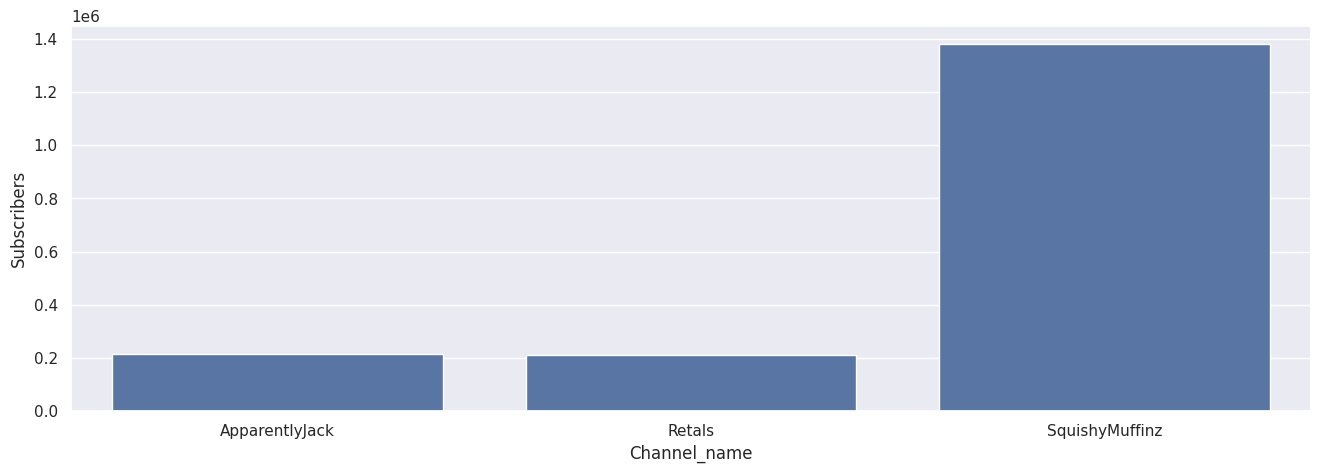

In [ ]:
sns.set(rc={'figure.figsize':(16,5)})
ax = sns.barplot(x='Channel_name', y='Subscribers', data=channels_data)

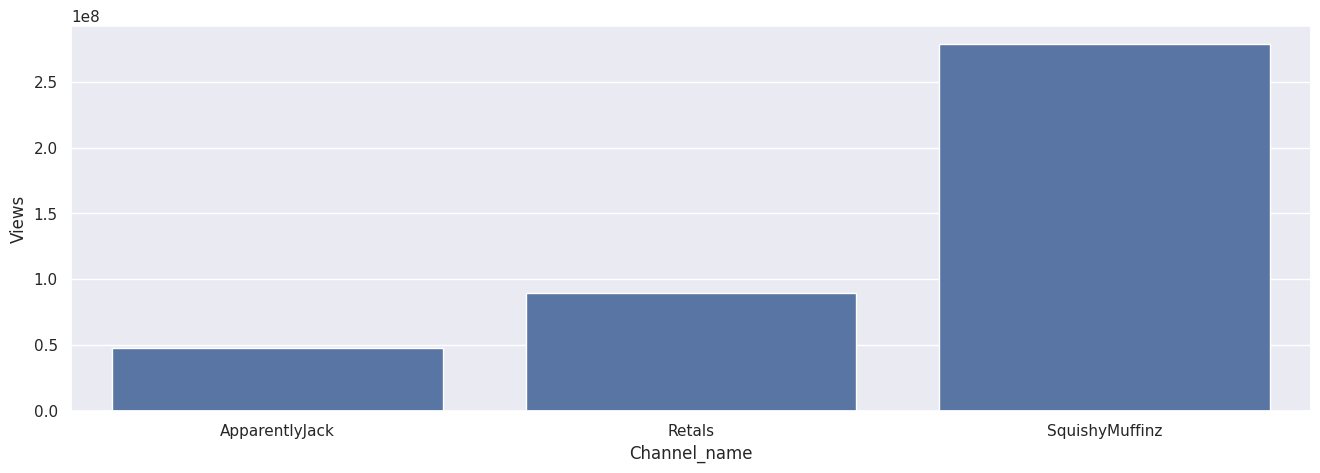

In [ ]:
ax = sns.barplot(x='Channel_name', y='Views', data=channels_data)

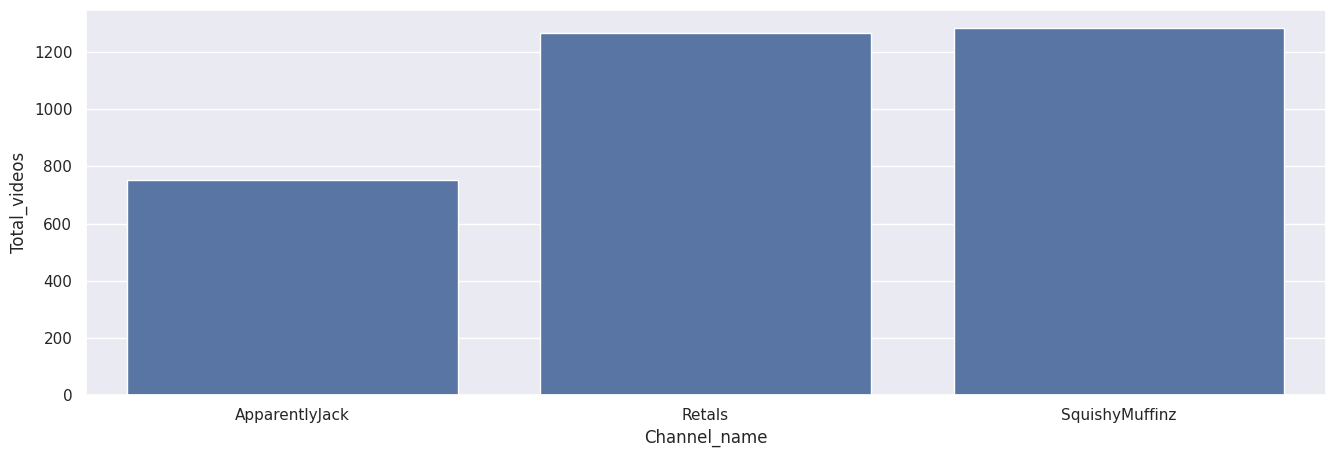

In [ ]:
ax = sns.barplot(x='Channel_name', y='Total_videos', data=channels_data)

## Funtion to get video id's

In [ ]:
channels_data

,Channel_name,Subscribers,Views,Total_videos,playlist_id
0,ApparentlyJack,216000,47789850,752,UURi4YlWuLFCucOx_rk-ddsg
1,Retals,210000,89675189,1267,UURLM6B6rGXDSJawUH_mHHPw
2,SquishyMuffinz,1380000,278467197,1283,UU1JPEwMqLaI96qRUKNp3_ow


In [ ]:
#index location of the first value (the playlist id of all the youtuber's videos)
playlist_ids = channels_data['playlist_id']
playlist_ids


,playlist_id
0,UURi4YlWuLFCucOx_rk-ddsg
1,UURLM6B6rGXDSJawUH_mHHPw
2,UU1JPEwMqLaI96qRUKNp3_ow


In [ ]:
def get_video_ids(youtube, playlist_ids):
  all_video_ids = []

  for playlist_id in playlist_ids:
    video_ids = []

    request = youtube.playlistItems().list(
                part = 'contentDetails',
                playlistId = playlist_id,
                maxResults = 50
                )

    response = request.execute()

    video_ids = []

    for i in range(len(response['items'])):
      video_ids.append(response['items'][i]['contentDetails']['videoId'])

    next_page_token = response.get('nextPageToken')
    more_pages = True

    while more_pages:
      if next_page_token is None:
        more_pages = False
      else:
        request = youtube.playlistItems().list(
                    part = 'contentDetails',
                    playlistId = playlist_id,
                    maxResults = 50,
                    pageToken = next_page_token)
        response = request.execute()

        for i in range(len(response['items'])):
          video_ids.append(response['items'][i]['contentDetails']['videoId'])

        all_video_ids.append(video_ids)

        next_page_token = response.get('nextPageToken')

  return all_video_ids

This function will grab all the video_ids for each youtuber and put them into a list.

In [ ]:
#playlist_id = 'UCRi4YlWuLFCucOx_rk-ddsg'
all_video_ids = get_video_ids(youtube, playlist_ids)

In [ ]:
import itertools
flattened_video_ids = list(set(itertools.chain(*all_video_ids)))

# all_video_ids = list(set(all_video_ids))

This will "flatten the list" and just combine all the id's from different youtubers into a one-dimensional list.

## Function to get video details

In [ ]:
def get_video_details(youtube, all_video_ids):

  all_video_stats = []

  for i in range(0, len(all_video_ids), 50):
    request = youtube.videos().list(
                part='snippet,statistics,contentDetails',
                id=','.join(all_video_ids[i:i+50]))
    response = request.execute()

    for video in response['items']:
      video_stats = dict(Video_ID = video['id'],
                         Title = video['snippet']['title'],
                         Description = video['snippet']['description'],
                         Published_date = video['snippet']['publishedAt'],
                         Views = video['statistics']['viewCount'],
                         Likes = video['statistics'].get('likeCount', 0),
                         Comments = video['statistics'].get('commentCount', 0),
                        #  Tags = tags,
                         Category_id = video['snippet']['categoryId'],
                         Duration = video['contentDetails']['duration'],
                         Definition = video['contentDetails']['definition'])

      all_video_stats.append(video_stats)

  return all_video_stats

This will just grab the Video Details for each of those videos.

Category Ids in this case will be "Gaming" most likely, but I want to pass this in to remove any others that may not be.

Category ID: 20 = Gaming

https://mixedanalytics.com/blog/list-of-youtube-video-category-ids/

In [ ]:
video_details = get_video_details(youtube, flattened_video_ids)

In [ ]:
video_data = pd.DataFrame(video_details)
video_data_sorted = video_data.sort_values(by='Published_date', ascending=False)





In [ ]:
video_data["Category_id"].value_counts()

,count
Category_id,
20,3301
22,1


#### Parsing the duration ISO 8601

In [ ]:
import re #Regular Expressions

def convert_duration_to_minutes(duration):
    if pd.isnull(duration):
        return np.nan  # If duration is NaN or None, return NaN

    # Ensure the duration is a string before processing
    duration = str(duration)

    # Use regular expression to parse duration (e.g., PT22M25S)
    match = re.match(r'PT(?:(\d+)H)?(?:(\d+)M)?(?:(\d+)S)?', duration)

    if not match:
        return np.nan  # If the duration doesn't match the expected format, return NaN

    hours = int(match.group(1)) if match.group(1) else 0
    minutes = int(match.group(2)) if match.group(2) else 0
    seconds = int(match.group(3)) if match.group(3) else 0

    # Convert everything to minutes
    total_minutes = hours * 60 + minutes + seconds / 60
    return total_minutes

In [ ]:
def convert_time_to_numeric(time_value):
    # Split the time into hours, minutes, and seconds
    time_value = str(time_value)
    hours, minutes, seconds = map(int, time_value.split(':'))

    # Convert minutes and seconds to a decimal value
    time_numeric = hours + (minutes / 60) + (seconds / 3600)

    return round(time_numeric, 2)  # Rounded to 2 decimal places

In [ ]:
video_data['Published_date'] = pd.to_datetime(video_data['Published_date'])  # Convert to datetime
video_data['Published_time'] = video_data['Published_date'].dt.time          # Extract time
video_data['Published_DOW'] = video_data['Published_date'].dt.strftime('%A')  # Corrected line
video_data['Published_date'] = video_data['Published_date'].dt.date
video_data['Views'] = pd.to_numeric(video_data['Views'])
video_data['Likes'] = pd.to_numeric(video_data['Likes'])
video_data['Comments'] = pd.to_numeric(video_data['Comments'])
video_data['Duration'] = video_data['Duration'].apply(lambda x: convert_duration_to_minutes(str(x)))
video_data['Published_time_numeric'] = video_data['Published_time'].apply(convert_time_to_numeric)




In [ ]:
# Only long-form videos (Duration > 3)
video_data = video_data[video_data['Duration'] > 3]

# Sort the filtered data by Duration in ascending order
video_data = video_data.sort_values(by='Duration', ascending=True)

# Display the result
video_data


,Video_ID,Title,Description,Published_date,Views,Likes,Comments,Category_id,Duration,Definition,Published_time,Published_DOW,Published_time_numeric
2063,Tox8HJjkG-0,Rocket League - Montage #4,Enjoy the 4th montage!! Thanks for 2k subscrib...,2016-01-25,29295,345,87,20,3.050000,hd,21:38:08,Monday,21.64
1832,X-OPYBd_MRY,Skate 3 Newest Glitch 2013 Fastest Speed Ever ...,This is a new way to get maximum speed and bey...,2013-11-02,32216,204,26,20,3.150000,hd,15:42:52,Saturday,15.71
1014,vv0N1o4Xatg,Learn How To WALL DASH In 3 MINUTES! (Rocket L...,Learn How To WALL DASH In 3 MINUTES! (Rocket L...,2023-10-24,270147,10840,471,20,3.150000,hd,19:25:56,Tuesday,19.43
5,q94Ma_FBwAA,Rocket League - 40k Montage,I hope you guys enjoyed this I'm so thankful f...,2016-11-12,205115,4947,627,20,3.166667,hd,05:50:05,Saturday,5.83
2140,JTe4W_-oByI,Rocket League - 15K Montage!!!!,Thank you all for the support can't thank you ...,2016-08-07,114732,2893,516,20,3.233333,hd,07:30:25,Sunday,7.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...
590,HPlbrrpYMmU,Musty replaces JSTN and helps us DOMINATE a Ro...,Twitter\nhttps://twitter.com/SquishyMuffinz\n\...,2021-12-07,1550541,17945,405,20,56.566667,hd,20:00:12,Tuesday,20.00
1194,Er8s6tdttRc,THE MOST DIFFICULT OBSTACLE COURSE IN THE GAME,Follow My Twitter: https://twitter.com/squishy...,2018-07-19,1674658,25319,1937,20,58.950000,hd,16:12:22,Thursday,16.21
2925,BxAunQ9lf44,OUR JOURNEY TO RLCS SEASON 6 WORLD CHAMPIONS (...,Follow me on twitch here: https://www.twitch.t...,2018-11-15,1510311,28879,1705,20,65.616667,hd,18:17:45,Thursday,18.30
1318,A0OO63LMmJ0,Road To RLCS: The Most Difficult Tournament of...,Visit my new second channel for games other th...,2024-05-22,62347,1435,128,20,75.866667,hd,17:00:14,Wednesday,17.00


All of the functions above are to parse the duration and the published time. We are then creating the columns for each video.

In [ ]:
video_data.dtypes

,0
Video_ID,object
Title,object
Description,object
Published_date,object
Views,int64
Likes,int64
Comments,int64
Category_id,object
Duration,float64
Definition,object


Here are the current columns for each video.

In [ ]:
top10_videos = video_data.sort_values(by='Views', ascending=False).head(10)
top10_videos

,Video_ID,Title,Description,Published_date,Views,Likes,Comments,Category_id,Duration,Definition,Published_time,Published_DOW,Published_time_numeric
2362,9KfvcHV6xww,Musty & I DOMINATE a Rocket League Tournament!...,Twitter\nhttps://twitter.com/SquishyMuffinz​​​...,2021-05-03,2603160,35271,1297,20,49.716667,hd,23:00:01,Monday,23.00
21,2qlyEWGd4RU,PLAYING AGAINST THE BEST 1V1 PLAYER IN THE WOR...,Follow me on twitch here: https://www.twitch.t...,2019-03-15,2484167,48899,1922,20,29.866667,hd,17:00:01,Friday,17.00
557,zSr1TZRbYUU,Intense Rocket League dribbling obstacle course.,Thanks for watching guys!!! :D\nMy Twitch: htt...,2017-09-20,1985307,30761,1601,20,19.266667,hd,00:24:15,Wednesday,0.40
308,bYveY7WuDo0,How To PERFECT Your Aerial Car Control In Rock...,EpicPartner Creator Code: SQUISHYMUFFINZ\n\nGe...,2021-03-05,1896792,68730,3136,20,15.333333,hd,22:00:07,Friday,22.00
1042,pkJeDHIttHM,INTENSE Rocket League Tournament With The BEST...,EpicPartner Creator Code: SQUISHYMUFFINZ\n\nGe...,2021-03-09,1872418,35975,2501,20,54.500000,hd,22:00:10,Tuesday,22.00
2627,1E_EMUelaaA,FINALLY REACHED THE #1 SPOT | 2 ALMOST INSANE ...,Thanks for watching! :D\n\nFollow My Twitter: ...,2018-01-16,1852386,23970,1585,20,23.333333,hd,04:58:10,Tuesday,4.97
1776,muWjcvMYjas,MAKING MY CAR ALL BLACK | CLEAN CROSS MAP AIR ...,Follow me on twitch here: https://www.twitch.t...,2019-11-15,1709575,33730,886,20,14.300000,hd,18:00:11,Friday,18.00
989,Lm_Px20PNa0,The NEW Lamborghini Huracan Is INSANE! | So Ma...,Twitter\nhttps://twitter.com/SquishyMuffinz​​​...,2021-04-22,1694323,47563,1219,20,17.116667,hd,00:00:03,Thursday,0.00
1194,Er8s6tdttRc,THE MOST DIFFICULT OBSTACLE COURSE IN THE GAME,Follow My Twitter: https://twitter.com/squishy...,2018-07-19,1674658,25319,1937,20,58.950000,hd,16:12:22,Thursday,16.21
590,HPlbrrpYMmU,Musty replaces JSTN and helps us DOMINATE a Ro...,Twitter\nhttps://twitter.com/SquishyMuffinz\n\...,2021-12-07,1550541,17945,405,20,56.566667,hd,20:00:12,Tuesday,20.00


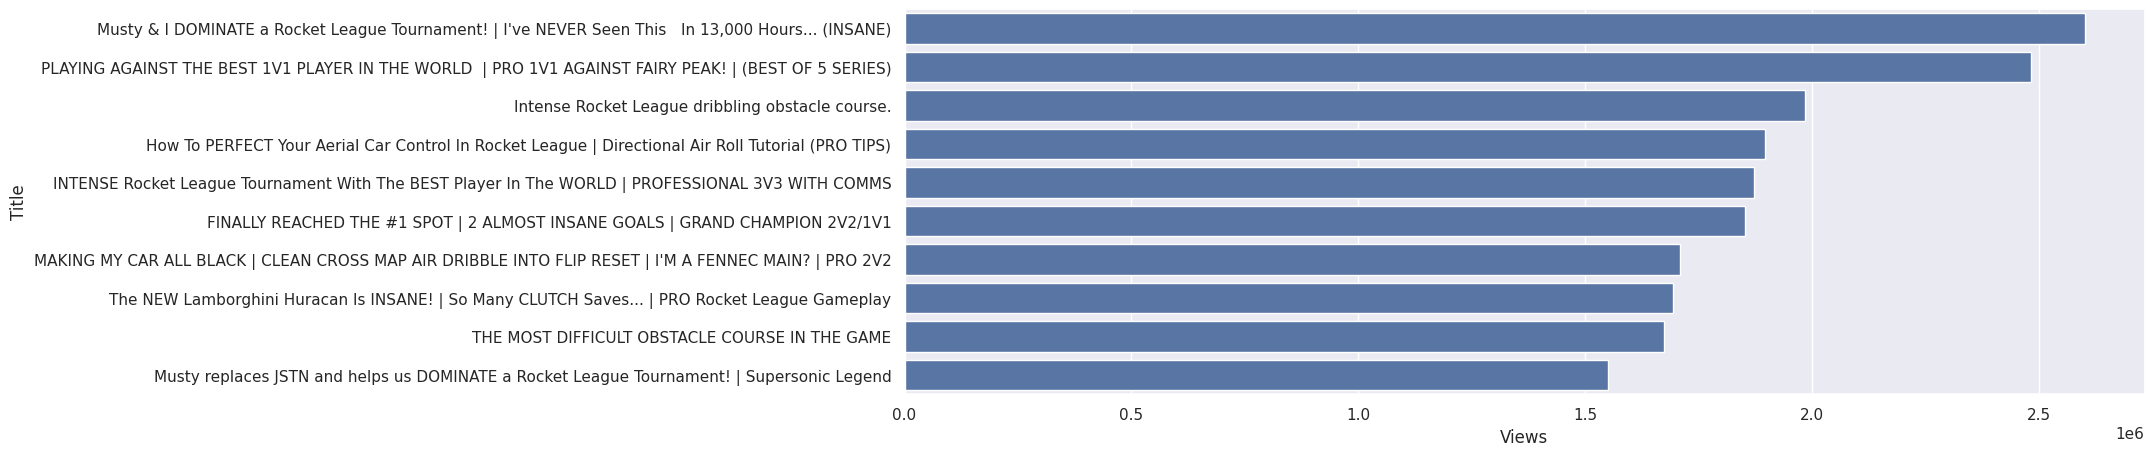

In [ ]:
ax1 = sns.barplot(x='Views', y='Title', data=top10_videos)

I just wanted to see the top10 videos between all of them.

In [ ]:
video_data['Month'] = pd.to_datetime(video_data['Published_date']).dt.strftime('%b')

In [ ]:
videos_per_month = video_data.groupby('Month', as_index=False).size()
videos_per_month

,Month,size
0,Apr,232
1,Aug,244
2,Dec,195
3,Feb,185
4,Jan,229
5,Jul,220
6,Jun,227
7,Mar,184
8,May,226
9,Nov,247


In [ ]:
sort_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
              'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

videos_per_month.index = pd.CategoricalIndex(videos_per_month['Month'], categories=sort_order, ordered=True)
videos_per_month = videos_per_month.sort_index()

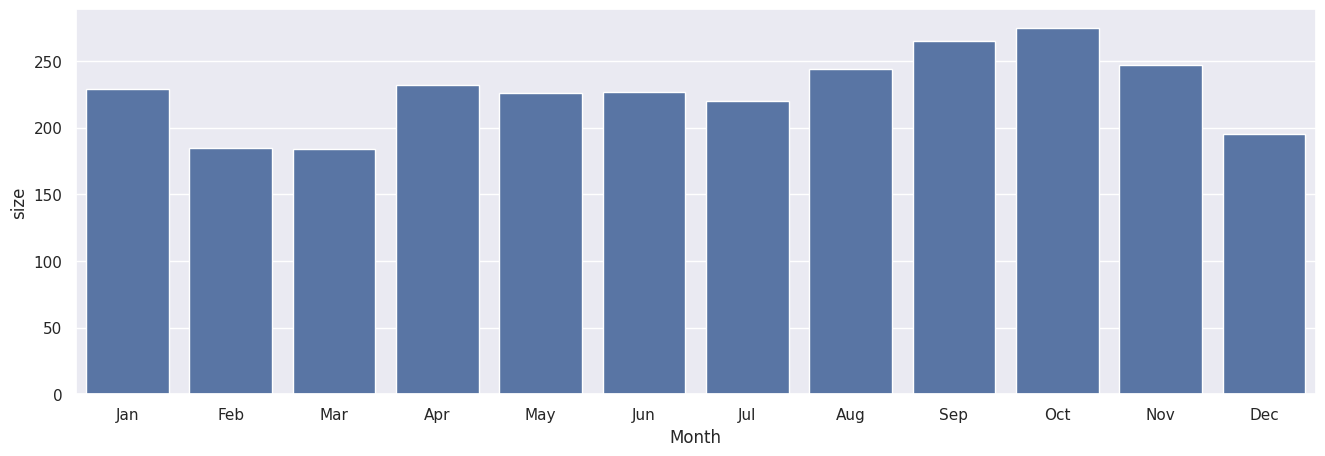

In [ ]:
ax2 = sns.barplot(x='Month', y='size', data=videos_per_month)

I wanted to see the amount of videos "in each month." To eventually see if some months do better than others. This is not for a specific year, now all of the videos have a "month" column.

# Exploratory Data Analyisis

"Video_data" will be a dataset of one of the Youtuber's I watch for now. In the future we will look into many Youtubers at once.

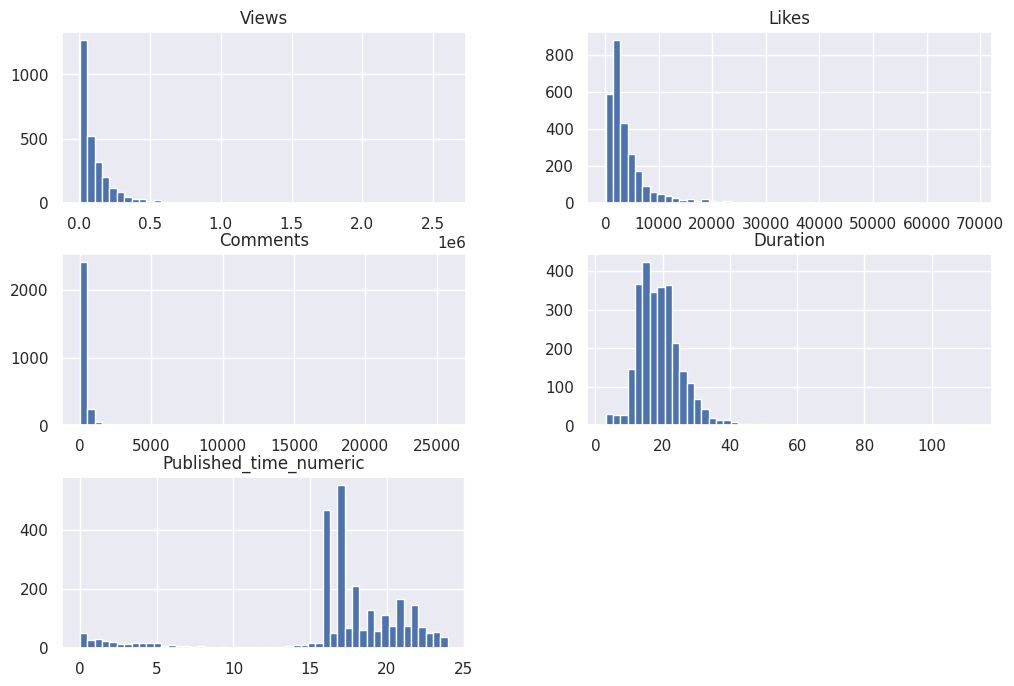

In [ ]:
video_data.hist(bins=50, figsize=(12, 8))
plt.show()

This is just to see the amount of videos in each category, for example it seems around 1700 videos fall into the 0-100,000 views range. And about 500 videos are posted around the same time (5ish PM it looks like).

In [ ]:
video_data.describe()

,Views,Likes,Comments,Duration,Published_time_numeric
count,2.729000e+03,2729.000000,2729.000000,2729.000000,2729.000000
mean,1.285622e+05,4285.639062,301.327226,19.121326,16.835383
std,1.929750e+05,5229.937747,648.648924,6.903418,5.308223
min,5.586000e+03,74.000000,18.000000,3.050000,0.000000
25%,3.414500e+04,1545.000000,104.000000,14.433333,16.010000
50%,6.392400e+04,2535.000000,182.000000,18.366667,17.010000
75%,1.500830e+05,4867.000000,354.000000,22.416667,20.050000
max,2.603160e+06,68730.000000,25763.000000,112.433333,23.960000


In [ ]:
train_set, test_set = train_test_split(video_data, test_size=0.2, random_state=42)

## Data Cleaning and Transformation


To figure out what keywords (in title and description, mostly title) might be useful for our model, we can first check out the correlations between each keyword and the views value.

Here we will take out filler words when finding the most common words used in titles and destriptions.

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

I download this package because I don't want random words like "the" and "I" used in titles.

In [ ]:
from collections import Counter
from nltk.corpus import stopwords



# videos_o_d = pd.read_csv('your_videos_data.csv')

# Combine title and description into a single column
#video_data['combined_text'] = video_data['Title'] + ' ' + video_data['Description']

# Function to clean and tokenize the text
stop_words = set(stopwords.words('english'))

# Function to clean and tokenize the text
def tokenize(text):
    # Lowercase and remove non-alphabetic characters
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize the text into words
    tokens = text.split()
    # Remove stop words and one-character words
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    return tokens

# Tokenize all combined text
all_words = video_data['Title'].apply(tokenize)

# Flatten the list of lists and count word frequencies
word_counts = Counter([word for sublist in all_words for word in sublist])

# Convert to DataFrame for easier handling
keyword_df = pd.DataFrame(word_counts.items(), columns=['keyword', 'count'])

# Sort by count in descending order
keyword_df = keyword_df.sort_values(by='count', ascending=False)

# Get the top 10 keywords
top_keywords = keyword_df.head(50)

print(top_keywords)

        keyword  count
0        rocket    813
1        league    795
21        grand    380
203         pro    345
146      insane    305
168        rank    300
20         road    296
111        best    289
83       ranked    285
41     champion    278
26          new    257
134      player    247
113         top    245
114        rlcs    241
172      legend    228
171  supersonic    224
257       world    208
76           vs    197
23       season    178
22        champ    141
247         ssl    137
197     playing    134
42           ep    129
225        team    126
39       double    120
19         flip    115
8          ever    114
82         game    108
362       comms    102
120     intense    100
264       games    100
426      played     98
224        like     94
313     players     79
234        play     77
74     garrettg     73
137       plays     72
330        back     71
364    teammate     67
49      squishy     65
37          air     63
316          iq     63
302       r

In [ ]:
# import warnings
# warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

# videos_o_d = videos_wo_outliers.dropna(subset=['description'])


video_data['title_length'] = video_data['Title'].apply(len)
video_data['description_length'] = video_data['Description'].apply(len)

video_data['title_word_count'] = video_data['Title'].apply(lambda x: len(x.split()))
video_data['description_word_count'] = video_data['Description'].apply(lambda x: len(x.split()))


vectorizer = CountVectorizer()
title_vectorized = vectorizer.fit_transform(video_data['Title'])
description_vectorized = vectorizer.fit_transform(video_data['Description'])


tfidf_vectorizer = TfidfVectorizer()
title_tfidf = tfidf_vectorizer.fit_transform(video_data['Title'])
description_tfidf = tfidf_vectorizer.fit_transform(video_data['Description'])

title_keywords = ['Rocket League', 'world', 'rlcs', 'top', 'ranked', 'rank up', 'prodigy', 'zen', 'SSL', 'settings', 'mechanic']  # Define your keywords
for keyword in title_keywords:
    video_data[f'has_{keyword.lower().replace(" ", "_")}_title'] = video_data['Title'].str.contains(keyword, case=False).astype(int)

description_keywords = ['Rocket League', 'SSL', 'Mechanics', 'Clips', 'Zen', 'Pro', 'RL', "rank"]  # Define your keywords
for keyword in description_keywords:
    video_data[f'has_{keyword.lower().replace(" ", "_")}_description'] = video_data['Description'].str.contains(keyword, case=False).astype(int)


# video_data.info()

This is first creating more columns for each video. We have description and title word count, which is obviously just getting the count of words in each title. Then we are creating binary columns like "has_rlcs_title" which is just a 1 or 0 if it has the word "rlcs" in the title or not.

**No that we have our keywords located in our dataset, let's see how they correlate to views!**
-------------------------------------

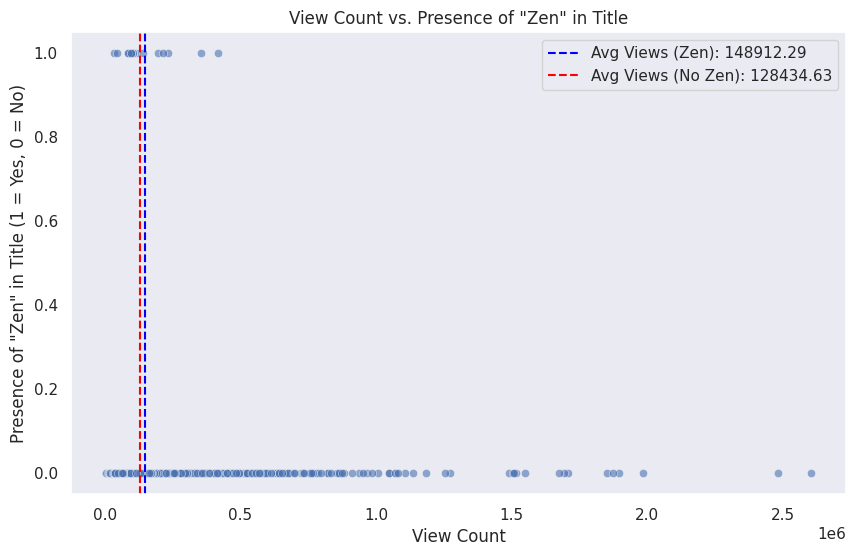

In [ ]:
avg_views_zen = video_data.loc[video_data['has_zen_title'] == 1, 'Views'].mean()
avg_views_no_zen = video_data.loc[video_data['has_zen_title'] == 0, 'Views'].mean()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=video_data, x='Views', y='has_zen_title', alpha=0.6)
plt.title('View Count vs. Presence of "Zen" in Title')
plt.xlabel('View Count')
plt.ylabel('Presence of "Zen" in Title (1 = Yes, 0 = No)')
plt.grid()

plt.axvline(avg_views_zen, color='blue', linestyle='--', label=f'Avg Views (Zen): {avg_views_zen:.2f}')
plt.axvline(avg_views_no_zen, color='red', linestyle='--', label=f'Avg Views (No Zen): {avg_views_no_zen:.2f}')

plt.legend()
plt.show()

Looking at this dataset you might be confused why I used the keyword "Zen." Well in simple terms, he's the Lamine Yamal, Messi, Ronaldo of Rocket League. Zen is what most rocket league players look up to, he's young and won the Rocket League World Championship right when he came into the league.

So yes it was a bit of cherry picking, but this shows that certain keywords can have a higher average of viwes.

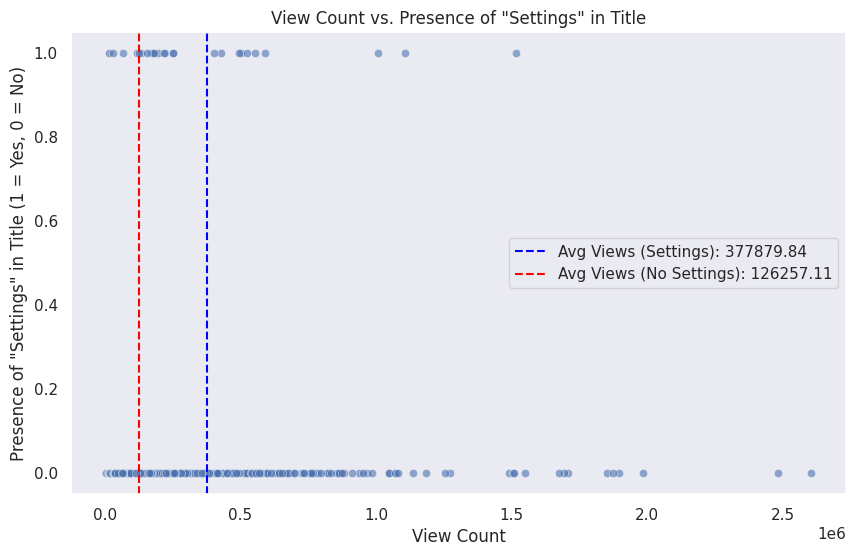

In [ ]:
avg_views_settings = video_data.loc[video_data['has_settings_title'] == 1, 'Views'].mean()
avg_views_no_settings = video_data.loc[video_data['has_settings_title'] == 0, 'Views'].mean()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=video_data, x='Views', y='has_settings_title', alpha=0.6)
plt.title('View Count vs. Presence of "Settings" in Title')
plt.xlabel('View Count')
plt.ylabel('Presence of "Settings" in Title (1 = Yes, 0 = No)')
plt.grid()

plt.axvline(avg_views_settings, color='blue', linestyle='--', label=f'Avg Views (Settings): {avg_views_settings:.2f}')
plt.axvline(avg_views_no_settings, color='red', linestyle='--', label=f'Avg Views (No Settings): {avg_views_no_settings:.2f}')

plt.legend()
plt.show()

This is a keyword that I guessed may be good to check, when you play something, in this case a game, "most of the time" you want to get better at said something. So if a professional or someone really good at the game (the youtuber I am analyzing) makes a video about "best settings to use," people will probably watch it.

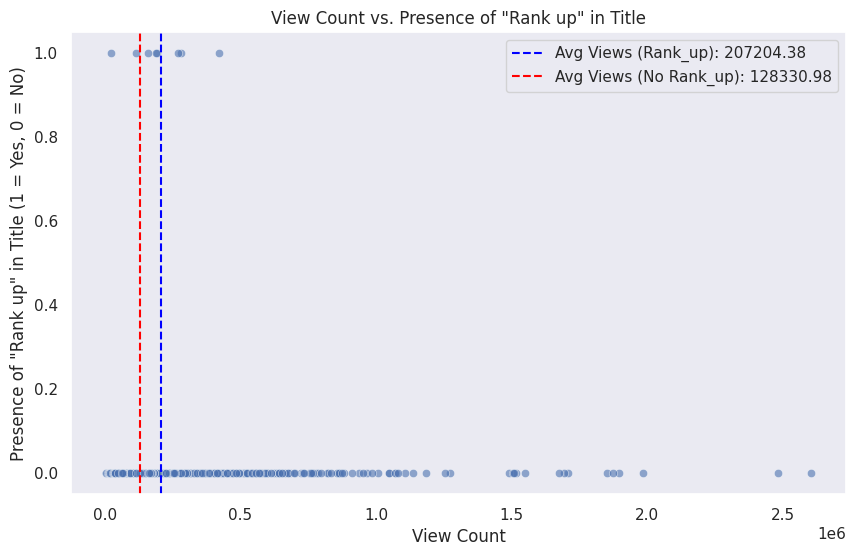

In [ ]:
avg_views_rankup = video_data.loc[video_data['has_rank_up_title'] == 1, 'Views'].mean()
avg_views_no_rankup = video_data.loc[video_data['has_rank_up_title'] == 0, 'Views'].mean()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=video_data, x='Views', y='has_rank_up_title', alpha=0.6)
plt.title('View Count vs. Presence of "Rank up" in Title')
plt.xlabel('View Count')
plt.ylabel('Presence of "Rank up" in Title (1 = Yes, 0 = No)')
plt.grid()

plt.axvline(avg_views_rankup, color='blue', linestyle='--', label=f'Avg Views (Rank_up): {avg_views_rankup:.2f}')
plt.axvline(avg_views_no_rankup, color='red', linestyle='--', label=f'Avg Views (No Rank_up): {avg_views_no_rankup:.2f}')

plt.legend()
plt.show()

Now there are those one-offs that may have just gotten lucky. I do believe having videos about "ranking up" has the same gist about adding the "settings" keyword, about people wanting to get better. So that could be a cause for why that one video has a good amount of views.

Alright last keyword for now.

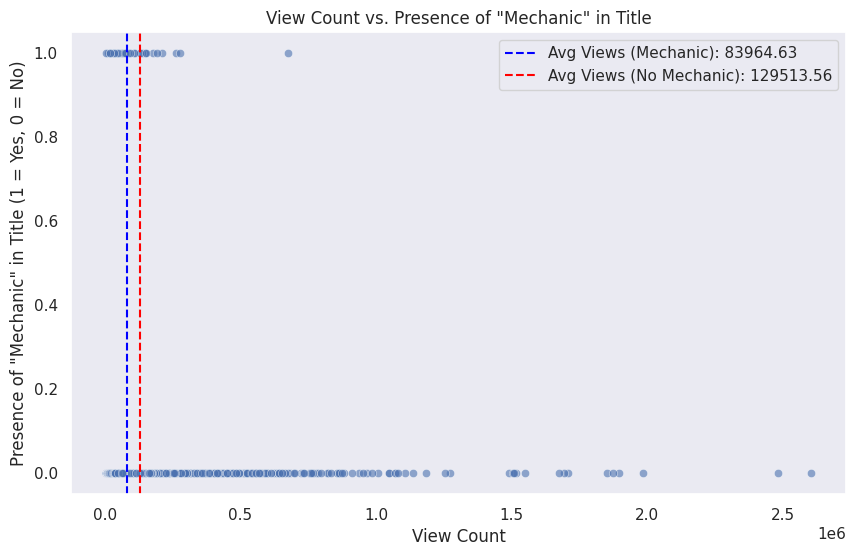

In [ ]:
avg_views_mechanic = video_data.loc[video_data['has_mechanic_title'] == 1, 'Views'].mean()
avg_views_no_mechanic = video_data.loc[video_data['has_mechanic_title'] == 0, 'Views'].mean()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=video_data, x='Views', y='has_mechanic_title', alpha=0.6)
plt.title('View Count vs. Presence of "Mechanic" in Title')
plt.xlabel('View Count')
plt.ylabel('Presence of "Mechanic" in Title (1 = Yes, 0 = No)')
plt.grid()

plt.axvline(avg_views_mechanic, color='blue', linestyle='--', label=f'Avg Views (Mechanic): {avg_views_mechanic:.2f}')
plt.axvline(avg_views_no_mechanic, color='red', linestyle='--', label=f'Avg Views (No Mechanic): {avg_views_no_mechanic:.2f}')

plt.legend()
plt.show()

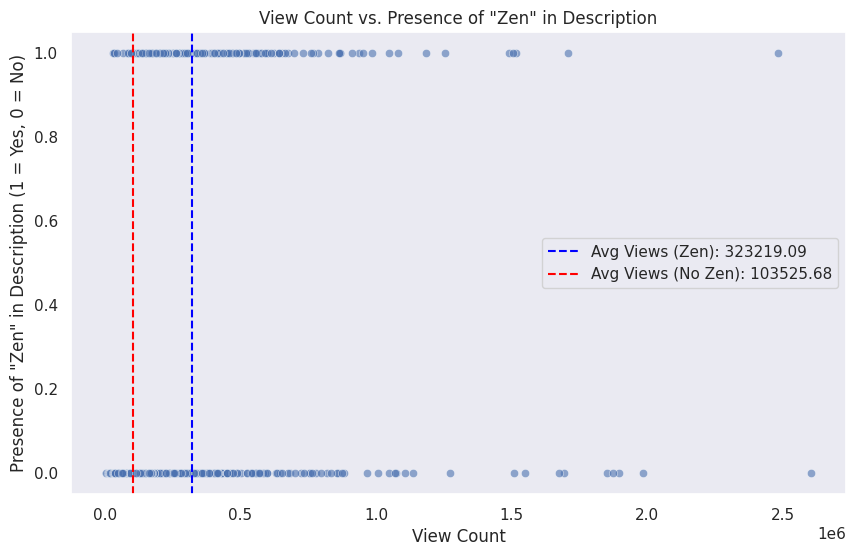

In [ ]:
avg_views_zen = video_data.loc[video_data['has_zen_description'] == 1, 'Views'].mean()
avg_views_no_zen = video_data.loc[video_data['has_zen_description'] == 0, 'Views'].mean()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=video_data, x='Views', y='has_zen_description', alpha=0.6)
plt.title('View Count vs. Presence of "Zen" in Description')
plt.xlabel('View Count')
plt.ylabel('Presence of "Zen" in Description (1 = Yes, 0 = No)')
plt.grid()

plt.axvline(avg_views_zen, color='blue', linestyle='--', label=f'Avg Views (Zen): {avg_views_zen:.2f}')
plt.axvline(avg_views_no_zen, color='red', linestyle='--', label=f'Avg Views (No Zen): {avg_views_no_zen:.2f}')

plt.legend()
plt.show()

This just has a slightly higher average with a few outliers, so I would not say this means much. But in Rocket League, people like to watch "Mechanical" players or learn "Mechanics," so this keyword wouldn't hurt to use somewhere in the title or description.

### Correlation Matrix (Correlation between something and views)

In [ ]:
corr_matrix = video_data.corr(numeric_only=True)

corr_matrix["Views"].sort_values(ascending=False)

,Views
Views,1.000000
Likes,0.901641
Comments,0.423786
title_length,0.368486
has_zen_description,0.361826
title_word_count,0.353454
description_length,0.250178
has_settings_title,0.124251
description_word_count,0.094681
has_rocket_league_title,0.081513


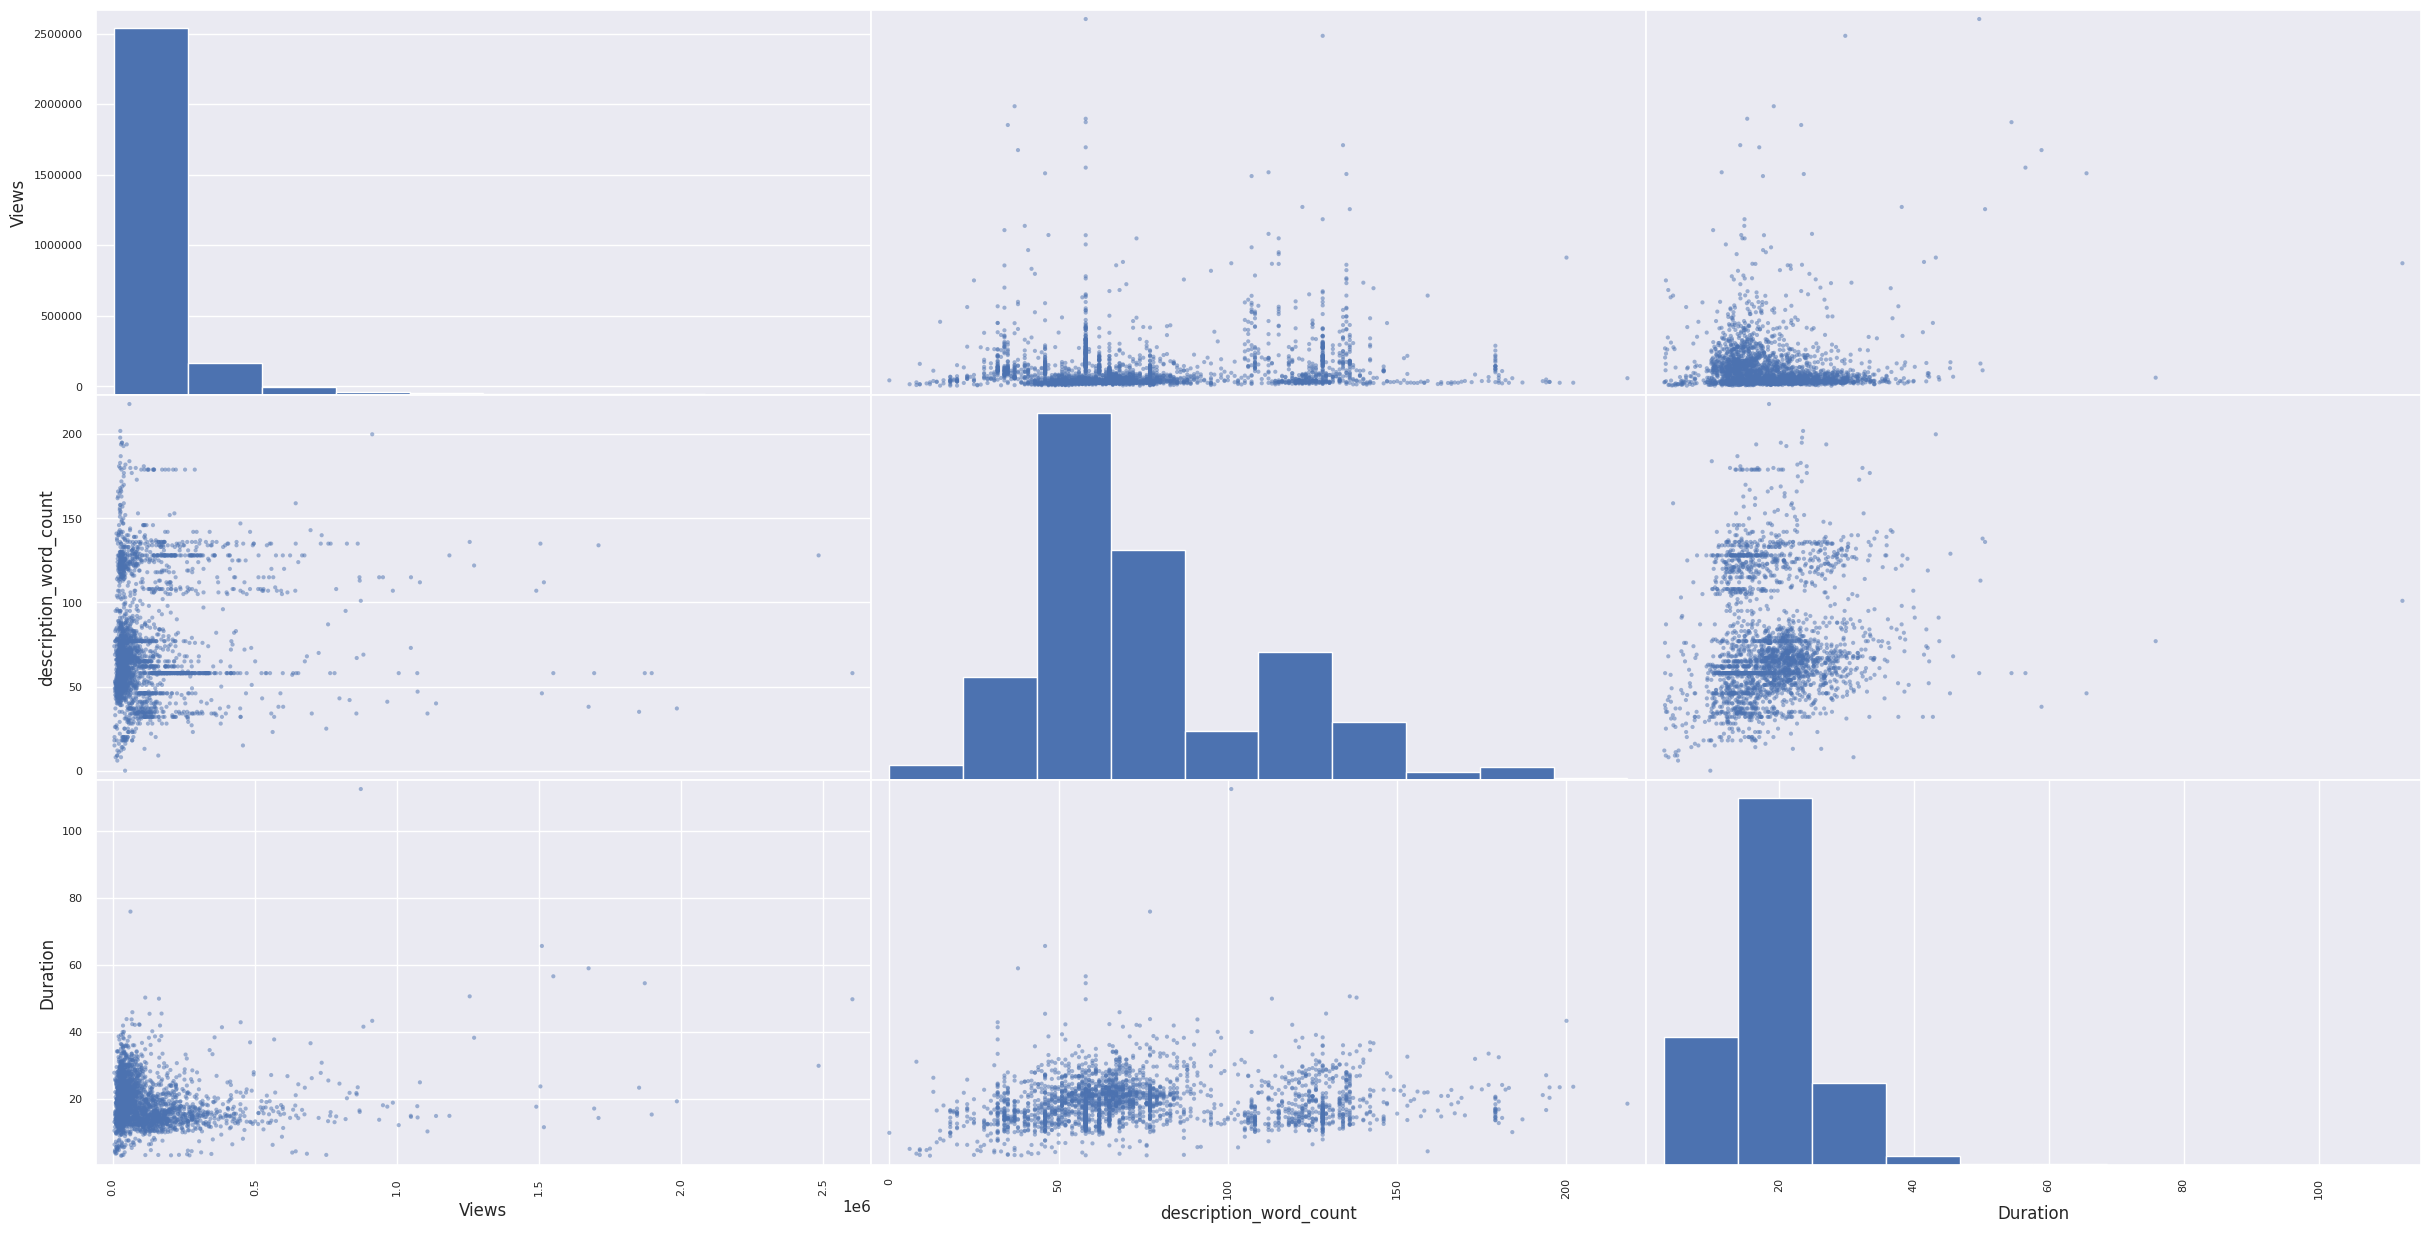

In [ ]:
attributes = ["Views", 'description_word_count', 'Duration']
pd.plotting.scatter_matrix(video_data[attributes], figsize=(30, 15))
plt.show()

Out of these numerical values we can see that the longer duration of a video, the average views go up. With the exception of a view outliers that we should probably remove for consistent data.

Not sure if it is correct, but looking at the description_word_count, as the description word count increases, the views decrease ever slow slightly. This could have many reasons, but so far that is what the data is showing.

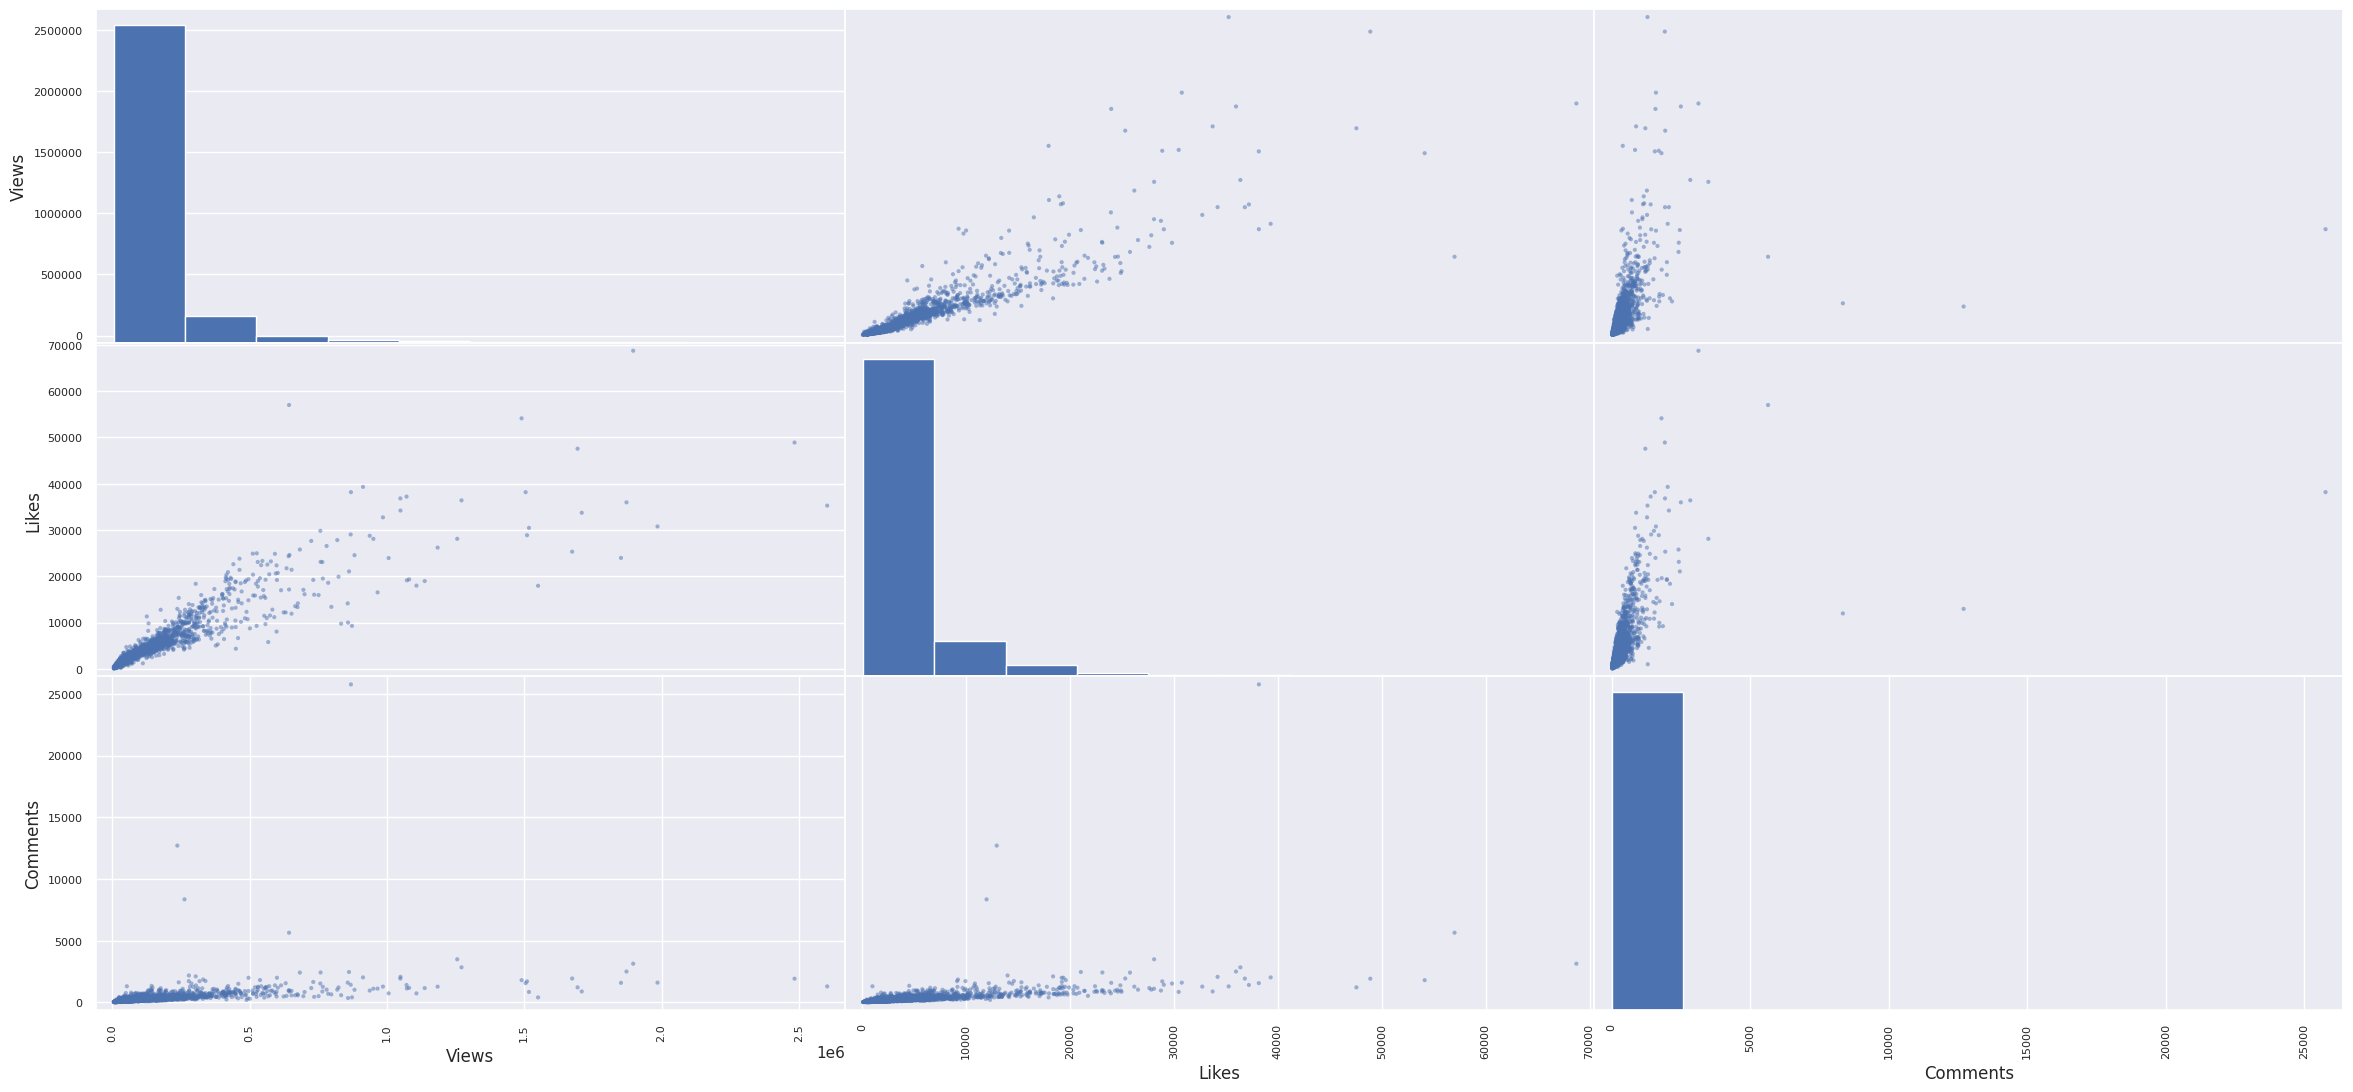

In [ ]:
attributes = ["Views", 'Likes', 'Comments']
pd.plotting.scatter_matrix(video_data[attributes], figsize=(29, 13))
plt.show()

As for Likes and Comments affecting views, this one is kind of a given loop. As the video gets more engagement (likes and comments), the video will get pushed out to more people to have them potentially view and engage the same. This is most likely why Youtubers push "like and comment for the algorithm," due to this positive correlation.

## Pipeline

In [ ]:
video_data['Definition'].value_counts()

,count
Definition,
hd,2729


In [ ]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Verify unique values in the cleaned Definition column
# print("Unique values in cleaned Definition column:", video_data['Definition'].unique())

# # Create the definition_category based on cleaned Definition values
# video_data['definition_category'] = video_data['Definition'].apply(
#     lambda x: 'sd' if x.lower() == 'sd'
#     else ('hd' if x.lower() == 'hd' else ('4K' if x.lower() == '4K' else 'unknown'))
# )

# # Verify the unique values in the definition_category column
# print("Unique values in definition_category:", video_data['definition_category'].unique())

# Define the numerical and categorical features
numerical_features = [
    'Likes',
    'Comments',
    'title_word_count',
    'description_word_count',
    'Duration',
    'Published_time_numeric'
]

# Update categorical features to include definition_category
categorical_features = [
    'has_settings_title',
    'has_rank_up_title',
    'Published_DOW',
]

# Create the numerical transformer
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
    ('scaler', StandardScaler())  # Scale numerical features
])

# Create the categorical transformer
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Handle missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # OneHotEncode categorical features
])

# Combine both transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Define the final pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Fit and transform the video data using the pipeline
video_prepared = pipeline.fit_transform(video_data[numerical_features + categorical_features])

# Check the shape of the prepared data
print(video_prepared.shape)

(2729, 17)


In [ ]:
# Get the feature names from the preprocessor
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Convert to a list if needed
feature_names_list = feature_names.tolist()

# Display the feature names
feature_names_list


['num__Likes',
 'num__Comments',
 'num__title_word_count',
 'num__description_word_count',
 'num__Duration',
 'num__Published_time_numeric',
 'cat__has_settings_title_0',
 'cat__has_settings_title_1',
 'cat__has_rank_up_title_0',
 'cat__has_rank_up_title_1',
 'cat__Published_DOW_Friday',
 'cat__Published_DOW_Monday',
 'cat__Published_DOW_Saturday',
 'cat__Published_DOW_Sunday',
 'cat__Published_DOW_Thursday',
 'cat__Published_DOW_Tuesday',
 'cat__Published_DOW_Wednesday']

# BIG QUESTION

**Main Question: What factors most significantly influence the number of views for Rocket League videos on YouTube?** (Obviously the youtube algorithm does its thing, so "significant" in this case will most likely be small)

In [ ]:
# # Split your dataset into training and testing sets
# X = video_data.drop('Views', axis=1)  # Features
# y = video_data['Views'] or other engagement in the future like comments and likes # Target variable

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Fit the pipeline on the training data
# pipeline.fit(X_train)

# # Transform the training and testing data
# X_train_transformed = pipeline.transform(X_train)
# X_test_transformed = pipeline.transform(X_test)

# # Now you can proceed with your model training using X_train_transformed and y_train

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Assuming video_prepared contains the transformed features
X = video_prepared  # Preprocessed data
y = video_data['Views']  # The target variable (Views)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the Ridge Regression model
model = Ridge(alpha=1.0)  # alpha is the regularization strength
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R-squared (how well the model fits the data)

# Print the results
print("Mean Squared Error:", mse)
print("R-squared:", r2)


Mean Squared Error: 5879571680.47054
R-squared: 0.8212782653615788


Of course this is with likes as a factor, but these don't seem "too bad" considering how volatile youtube data is.

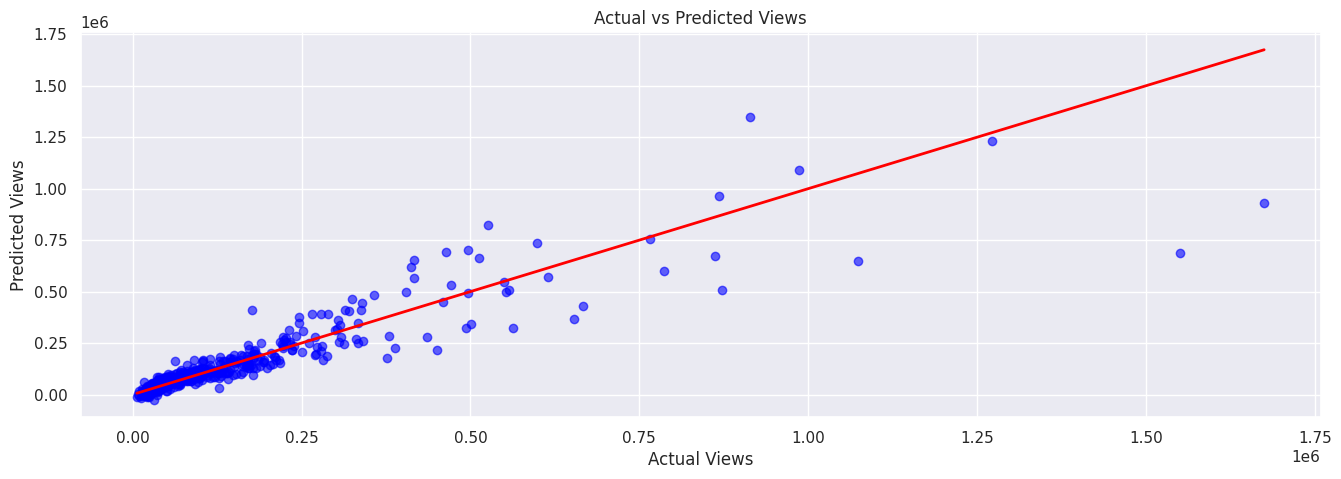

In [ ]:
import matplotlib.pyplot as plt

# Plot actual vs predicted views
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)  # Diagonal line
plt.title('Actual vs Predicted Views')
plt.xlabel('Actual Views')
plt.ylabel('Predicted Views')
plt.show()


The red diagonal line represents perfect predictions (where actual = predicted). The closer the scatter points are to this line, the better the model is performing.

                         Feature    Coefficient
0                     num__Likes  181276.024123
7      cat__has_settings_title_1   36584.047957
6      cat__has_settings_title_0  -36584.047957
9       cat__has_rank_up_title_1  -35759.609173
8       cat__has_rank_up_title_0   35759.609173
4                  num__Duration   16291.201670
1                  num__Comments  -10820.580678
5    num__Published_time_numeric   -8182.077173
10     cat__Published_DOW_Friday    6619.146812
3    num__description_word_count   -6189.274073
12   cat__Published_DOW_Saturday   -5805.369813
14   cat__Published_DOW_Thursday   -2002.940523
15    cat__Published_DOW_Tuesday    1302.108090
2          num__title_word_count    1295.884050
11     cat__Published_DOW_Monday    -325.511568
13     cat__Published_DOW_Sunday     140.448063
16  cat__Published_DOW_Wednesday      72.118939


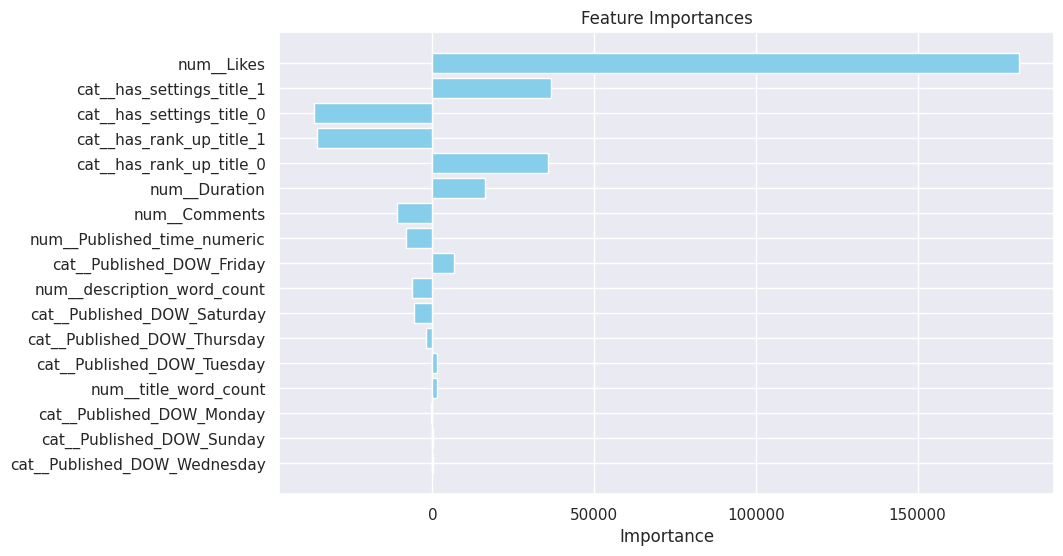

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature names and corresponding coefficients
coefficients = model.coef_

# Create a DataFrame to display the feature names and their coefficients
feature_importance = pd.DataFrame({
    'Feature': feature_names_list,
    'Coefficient': coefficients
})

# Sort by the absolute value of coefficients
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

# Print the sorted feature importance
print(feature_importance[['Feature', 'Coefficient']])

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # To show the most important features at the top
plt.show()


Here are the features! I kept the likes in to show the insane positive correlation/ feedback loop.

Ending result: Post on friday, longer video is better (Under 1hr as that was around the max of the dataset), people like settings videos, and get the viewers to like the video!